# Inference: SMC

This example shows you how to perform Bayesian inference on a time series, using SMC implemented in PyMC3 and Theano.

SMC:
* https://doi.org/10.1061/(ASCE)0733-9399(2007)133:7(816)

PyMC3:
* http://doi.org/10.18637/jss.v035.i04

Theano:
* http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.691.4524

In [1]:
from __future__ import print_function
import pints
reload(pints)
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.BayesianLogLikelihood(prior, log_likelihood)

# Run a simple adaptive mcmc routine
x0 = real_parameters * 1.1
smc = pints.SMC(log_likelihood, x0)
chain = smc.run()


/home/scratch/anaconda3/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/smc.py:480: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/scratch/anaconda3/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.000001 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.000004 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.000016 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.000034 Stage: 4
Initialising chain traces ...
Sampling ...
Beta: 0.000070 Stage: 5
Initialising chain t

In [2]:
# Get marginal likelihood
print(smc.marginal_likelihood())

4.00946540692e-10


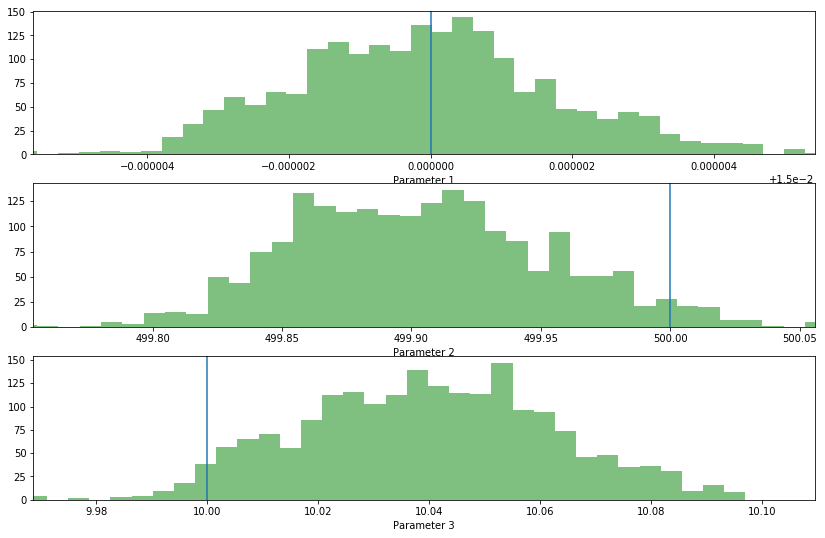

In [3]:
# Plot output
pl.figure(figsize=(14, 9))
for i, real in enumerate(real_parameters):
    
    # Add subplot
    pl.subplot(len(real_parameters), 1, 1+i)
    pl.xlabel('Parameter ' + str(i + 1))
    
    # Show true value
    pl.axvline(real)
    
    # Show histogram of chain
    pl.hist(chain[:,i], label='p' + str(i + 1), bins=40, color='green',
        alpha=0.5)
    
    # Center plot around mean of chain
    mu = np.mean(chain[:,i])
    sigma = np.std(chain[:,i])
    pl.xlim(mu - 3 * sigma, mu + 3 * sigma)

pl.show()